## Generate a PSD plot framework for future plots (this one first uses double integration to convert raw acceleration to raw displacement).

In [1]:
#Purisa Jasmine Simmons
#August 2018

#Overview: PSD for E3 (Buoy_Calibrator1), trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from a controlled experiment (CE3), so we are assuming that 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy.signal import butter, lfilter, freqz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


In [2]:
ride_ids = ['14827']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29)

In [3]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    



In [4]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)


https://surf.smartfin.org/ride/14827
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180723164430_Ocean.CSV
                               Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                            
2018-07-23 16:44:42.467  1370665472            493                    30.812   
2018-07-23 16:44:48.487  1370671492            496                    31.000   
2018-07-23 16:44:54.507  1370677512            499                    31.188   
2018-07-23 16:45:00.528  1370683533            500                    31.250   
2018-07-23 16:45:06.549  1370689554            500                    31.250   
2018-07-23 16:45:12.569  1370695574            502                    31.375   
2018-07-23 16:45:18.591  1370701596            502                    31.375   
2018-07-23 16:45:24.612  1370707617            504                    31.500   
2018-07-23 16:45:30.634  1370713639            505         

## Make a copy of the original motion_df dataframe

In [5]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
14827   2018-07-23 16:44:42.915  1.370666e+09   138.0  -380.0   333.0 -1115.0   
        2018-07-23 16:44:42.948  1.370666e+09   181.0  -459.0   225.0  -720.0   
        2018-07-23 16:44:42.981  1.370666e+09   108.0  -446.0   291.0  -976.0   
        2018-07-23 16:44:43.014  1.370666e+09   133.0  -401.0   275.0  -558.0   
        2018-07-23 16:44:43.047  1.370666e+09   153.0  -415.0   101.0  -799.0   
        2018-07-23 16:44:43.080  1.370666e+09    46.0  -435.0   307.0  -760.0   
        2018-07-23 16:44:43.113  1.370666e+09   243.0  -324.0   412.0  -247.0   
        2018-07-23 16:44:43.146  1.370666e+09   281.0  -382.0   311.0   -69.0   
        2018-07-23 16:44:43.179  1.370666e+09   217.0  -412.0   135.0   323.0   
        2018-07-23 16:44:43.212  1.370666e+09   341.0  -546.0    56.0   190.0   
        2018-07-23 16:44:43.

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [6]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3'])

#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []

imu1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array1 = []

imu2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array2 = []

imu3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array3 = []


#Get all the times and imus where time, imu1, imu2, and imu3 are NOT nan values:
for t,x,y,z in zip(time_array_nans, imu1_array_nans, imu2_array_nans, imu3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array1.append(x)
        imu_array2.append(y)
        imu_array3.append(z)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    
    #print(prev, " ", after)
    #print(after - prev)
    
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1


##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array1[-1])
del(imu_array2[-1])
del(imu_array3[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu_array1))
print(len(imu_array2))
print(len(imu_array3))





23432
23432
23432
23432
23432


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

23432
23432
23432
Graph of our entire experiment:


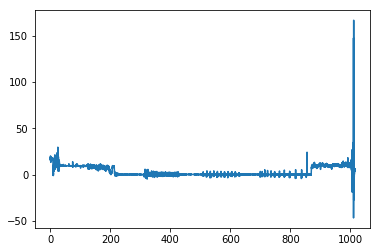

In [7]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = -9.80665


# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity - gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

##To check:
#for x,y in zip(imu2_array, imu_array2):
#    print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imu2_array))

print("Graph of our entire experiment:")

plt.plot(time_e_array, imu2_array)
plt.show()

#print("Why are the y-axis values so small?")

## PSD Step 1: Seperate each of the subexperiments into its own acc lists

In [8]:
#for x in time_e_array:
#    print(x)

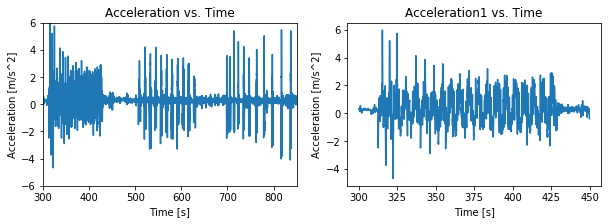

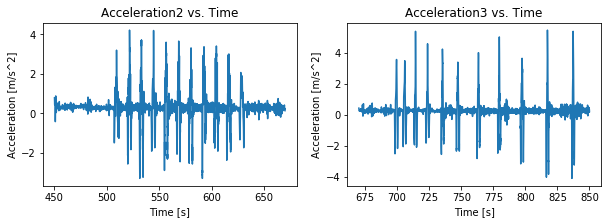

In [9]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []

gravity = -9.80665

#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 300 and time_e_array[i] <= 450):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 450 and time_e_array[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 670 and time_e_array[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
for a,t in zip(acc_list,time_e_array): #acc_array becomes only acc values we care about
    if t > 300 and t <= 850:
        acc_array.append(a)
        time_array.append(t)

time_array = np.array(time_array)
acc_array = np.array(acc_array)
time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Acceleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_xlim([300,850])
ax1.set_ylim([-6,6])

ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])

ax3.plot(time_array2, acc_array2)
ax3.set_title("Acceleration2 vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Acceleration [m/s^2]")
#ax3.set_ylim([-6,6])

ax4.plot(time_array3, acc_array3)
ax4.set_title("Acceleration3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Acceleration [m/s^2]")
#ax4.set_ylim([-6,6])

plt.show()
    

## PSD Step 2: Data Processing and Filtering

In [10]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

##Remove outliers--points greater than 3x the standard deviation
std1 = np.std(dacc_array1)*3
std2 = np.std(dacc_array2)*3
std3 = np.std(dacc_array3)*3

#Returns a new array that is the same as the array passed in, with its outliers removed.
def removed_outliers(a_array, time_array, std):
    i = 0
    count = 0
    ret_accs = []
    ret_times = []
    while i < (len(a_array)):
        #if smaller than std, keep that value (larger ones get removed)
        if abs(a_array[i]) < std:
            ret_accs.append(a_array[i])
            ret_times.append(time_array[i])
        else:
            count = count + 1  #could help with debugging to know how many outliers removed
        i = i + 1  
    return count, ret_accs, ret_times;
        
count1, ro_array1, ro_time1 = removed_outliers(dacc_array1, time_array1, std1)
count2, ro_array2, ro_time2 = removed_outliers(dacc_array2, time_array2, std2)
count3, ro_array3, ro_time3 = removed_outliers(dacc_array3, time_array3, std3)

#print(len(dacc_array1))
#print(count1)
#print(len(ro_array1))

##Set up data interpolation (using Cubic Splines) for use in next step
cs1 = CubicSpline(ro_time1, ro_array1)
cs2 = CubicSpline(ro_time2, ro_array2)
cs3 = CubicSpline(ro_time3, ro_array3)


##interpld returns a function that relates y=ro_array (without outliers) to x=time:
#cs1 = interp1d(ro_time1, ro_array1)
#cs2 = interp1d(ro_time2, ro_array2)
#cs3 = interp1d(ro_time3, ro_array3)

#Now, use this interpolation to put points back into the original graph:
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


#These are the new arrays with the interpolated points (which we will
#feed into a Kalman filter later).
interp_array1 = add_interpolated_pts(dacc_array1, time_array1, std1, cs1)
interp_array2 = add_interpolated_pts(dacc_array2, time_array2, std2, cs2)
interp_array3 = add_interpolated_pts(dacc_array3, time_array3, std3, cs3)


#print(len(interp_array1))
#print(len(dacc_array1))

##To verify that the two arrays are different(i.e. pts were actually interpolated):
j = 0
count = 0
while (j < (len(interp_array1) - 1)):
    if interp_array1[j] != dacc_array1[j]:
        count = count + 1
    j = j + 1
        
#print(count)
    

## Plot all of the data, to see visually:

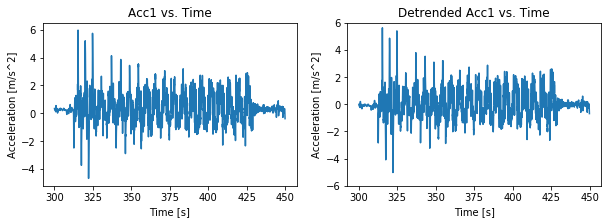

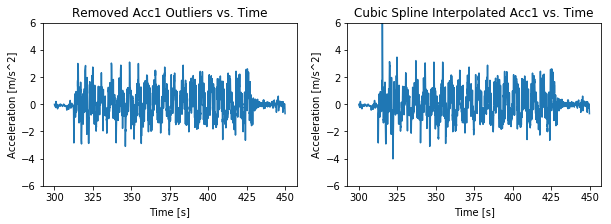

In [11]:
##Plotting the results for the 1st sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array1, acc_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
#ax1.set_ylim([-6,6])

ax2.plot(time_array1, dacc_array1)
ax2.set_title("Detrended Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

ax3.plot(ro_time1, ro_array1)
ax3.set_title('Removed Acc1 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])

ax4.plot(time_array1, interp_array1)
ax4.set_title("Cubic Spline Interpolated Acc1 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()

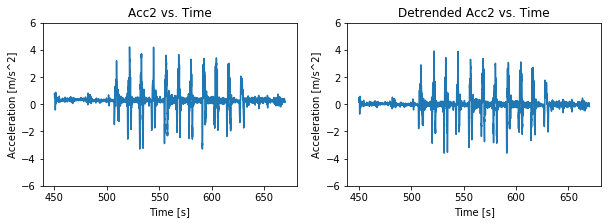

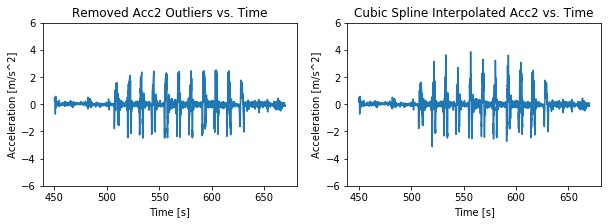

In [12]:
##Plotting the results for the 2nd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array2, acc_array2)
ax1.set_title('Acc2 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array2, dacc_array2)
ax2.set_title("Detrended Acc2 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time2, ro_array2)
ax3.set_title('Removed Acc2 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array2, interp_array2)
ax4.set_title("Cubic Spline Interpolated Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()




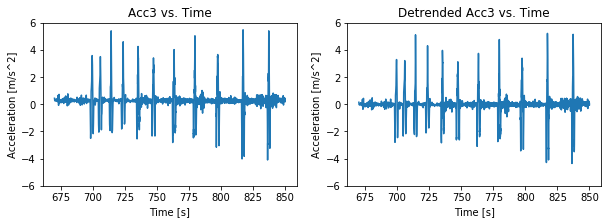

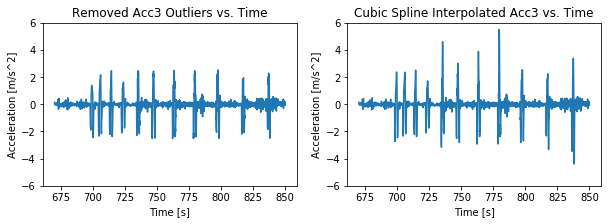

In [13]:
##Plotting the results for the 3rd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array3, acc_array3)
ax1.set_title('Acc3 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array3, dacc_array3)
ax2.set_title("Detrended Acc3 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time3, ro_array3)
ax3.set_title('Removed Acc3 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array3, interp_array3)
ax4.set_title("Cubic Spline Interpolated Acc3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()

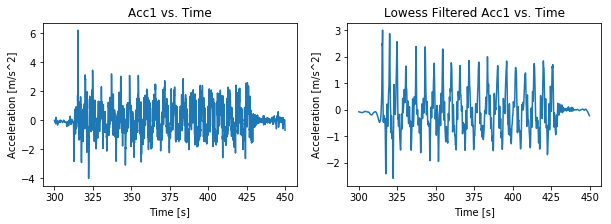

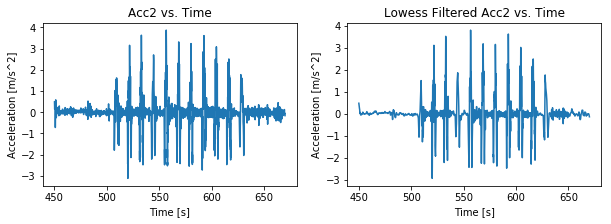

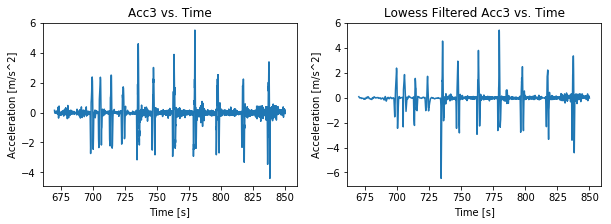

In [14]:
##Now, feed interpolated arrays through a Kalman filter:
##(Actually I'm going to use a LOWESS filter for simplicity)

#print("\n")
#print("Here, I'm implementing a lowess filter instead of a Kalman \n filter right now because it seems simpler to implement.")
#print("\n")

lowess = sm.nonparametric.lowess

#Parameters: takes in (y,x, ...)
filtered1 = lowess(interp_array1, time_array1, frac=0.005, is_sorted=True, return_sorted=False) 
filtered2 = lowess(interp_array2, time_array2, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3 = lowess(interp_array3, time_array3, frac=0.002, is_sorted=True, return_sorted=False) 


##Plotting the filtered results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(time_array1, interp_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(time_array1, filtered1)
ax2.set_title("Lowess Filtered Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc2
ax3.plot(time_array2, interp_array2)
ax3.set_title('Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(time_array2, filtered2)
ax4.set_title("Lowess Filtered Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc3
ax5.plot(time_array3, interp_array3)
ax5.set_title('Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(time_array3, filtered3)
ax6.set_title("Lowess Filtered Acc3 vs. Time")
ax6.set_xlabel("Time [s]")
ax6.set_ylabel('Acceleration [m/s^2]')

plt.show()

#print("Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better \n than the original.")


## 

In [16]:
##Instead of doing PSD here, do what we did in the last experiment (with the buoy calibrator):

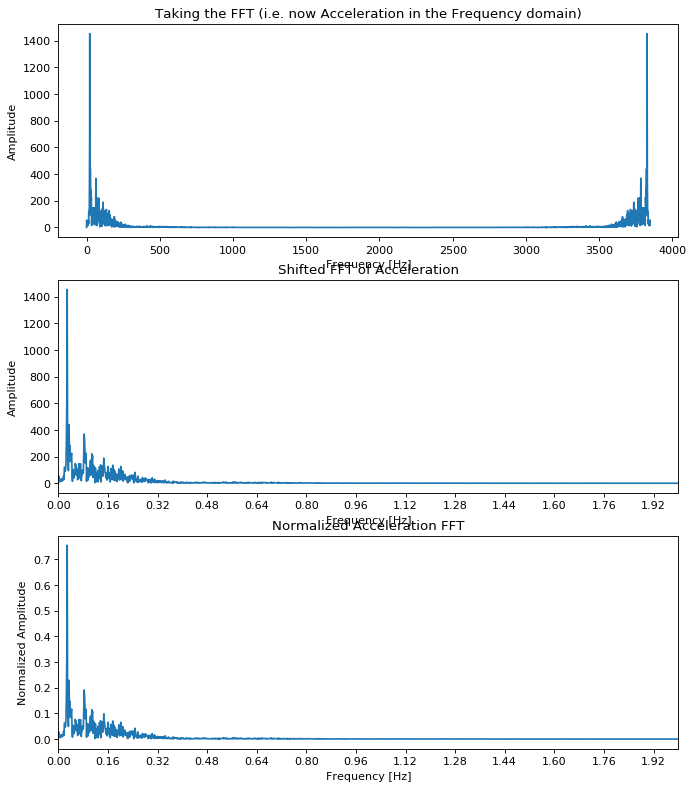

This is the output after shifting the FFT of the second derivative 
 i.e. the FFT of acceleration.
This looks promising since the amplitude of the last graph matches the amplitude of the acceleration graph from the second derivative (above).


In [17]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(filtered1)
dacc_array2 = signal.detrend(filtered2)
dacc_array3 = signal.detrend(filtered3)

f_s = 5.0 #sampling frequency

#Taking the FFT of acceleration:
fft_acc1 = np.fft.fft(dacc_array1)
len_fft_acc1 = len(fft_acc1)
freq_acc1 = np.fft.fftfreq(len_fft_acc1, 1/f_s)

#Shifting the FFT of acceleration:
fft_acc1_shifted = np.fft.fftshift(fft_acc1)
freq_acc1_shifted = np.fft.fftshift(freq_acc1)

#Normalize:
fft_acc1_normal = np.abs(fft_acc1_shifted/len_fft_acc1)*2

#Plot:
fig = plt.figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')


# Returns the Axes instance
ax1 = fig.add_subplot(311) 
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


ax1.plot(np.abs(fft_acc1))
ax1.set_title('Taking the FFT (i.e. now Acceleration in the Frequency domain)')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_acc1_shifted, np.abs(fft_acc1_shifted))
ax2.set_title('Shifted FFT of Acceleration')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')
ax2.set_xlim(0,2)
ax2.set_xticks(np.arange(0,2, step=.16))

ax3.plot(freq_acc1_shifted, fft_acc1_normal)
ax3.set_title('Normalized Acceleration FFT')
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('Normalized Amplitude')
ax3.set_xlim(0,2)
ax3.set_xticks(np.arange(0,2, step=.16))

plt.show()

print("This is the output after shifting the FFT of the second derivative \n i.e. the FFT of acceleration.")
print("This looks promising since the amplitude of the last graph matches the amplitude of the acceleration graph from the second derivative (above).")





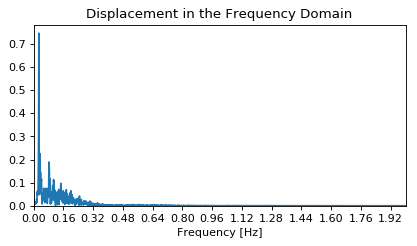

In [18]:
#Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:
f = 0.16

w = 2*np.pi*f
omega = 1/w**2

disp1_normal = []

for a in fft_acc1_normal:
    new_a = a*omega
    disp1_normal.append(new_a)

#So now new_list should have the new values, 
#representing displacement in the frequency domain.
fig = plt.figure(num=None, figsize=(6,3), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(111) 


ax.plot(freq_acc1_shifted, disp1_normal)
ax.set_title("Displacement in the Frequency Domain")
ax.set_xlabel('Frequency [Hz]')
plt.xlim(0,2)
plt.ylim(0,)
plt.xticks(np.arange(0,2, step=.16))

plt.show()

In [75]:
def calc_displacement_fft(acc_array, f_s): 
    
    ##PSD Step 2: Detrend the data 
    dacc_array = signal.detrend(acc_array)

    #Taking the FFT of acceleration:
    fft_acc = np.fft.fft(dacc_array)
    len_fft_acc = len(fft_acc)
    freq_acc = np.fft.fftfreq(len_fft_acc, 1/f_s)

    #Shifting the FFT of acceleration:
    fft_acc_shifted = np.fft.fftshift(fft_acc)
    freq_acc_shifted = np.fft.fftshift(freq_acc)

    #Normalize:
    fft_acc_normal = np.abs(fft_acc_shifted/len_fft_acc)*2


    #Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:

    f = 0.16  #Need to not hardcode this number - find it using max.

    w = 2*np.pi*f
    omega = 1/w**2

    disp_normal = []

    for a in fft_acc_normal:
        new_a = a*omega
        disp_normal.append(new_a)

    #So now disp_normal should have the new values, 
    #representing displacement in the frequency domain.

    
    #Calculating wave statistics
    peak_freq = np.abs(freq_acc_shifted[np.argmax(disp_normal)])
    wave_height = disp_normal[np.argmax(disp_normal)]*2 #multiply by 2 because total height is from peak to trough
    
    
    
    
    #Plot:
    fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')


    # Returns the Axes instance
    ax1 = fig.add_subplot(221) 
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224) 


    ax1.plot(np.abs(fft_acc))
    ax1.set_title('Taking the FFT (i.e. now Acceleration in the Frequency domain)')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude')

    ax2.plot(freq_acc_shifted, np.abs(fft_acc_shifted))
    ax2.set_title('Shifted FFT of Acceleration')
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Amplitude')
    ax2.set_xlim(0,2)
    ax2.set_xticks(np.arange(0,2, step=.2))

    ax3.plot(freq_acc_shifted, fft_acc_normal)
    ax3.set_title('Normalized Acceleration FFT')
    ax3.set_xlabel('Frequency [Hz]')
    ax3.set_ylabel('Normalized Amplitude')
    ax3.set_xlim(0,2)
    ax3.set_xticks(np.arange(0,2, step=.2))
    
    ax4.plot(freq_acc_shifted, disp_normal)
    ax4.set_title("Displacement in the Frequency Domain")
    ax4.set_xlabel('Frequency [Hz]')
    ax4.axvline(x=peak_freq, linewidth=3, color='orange', alpha=0.5)
    ax4.set_xlim(0,2)
    ax4.set_ylim(0,)
    ax4.set_xticks(np.arange(0,2, step=.2))

    plt.show()


    print("Peak frequency is: ", peak_freq)
    print("Wave height is: ", wave_height)

    

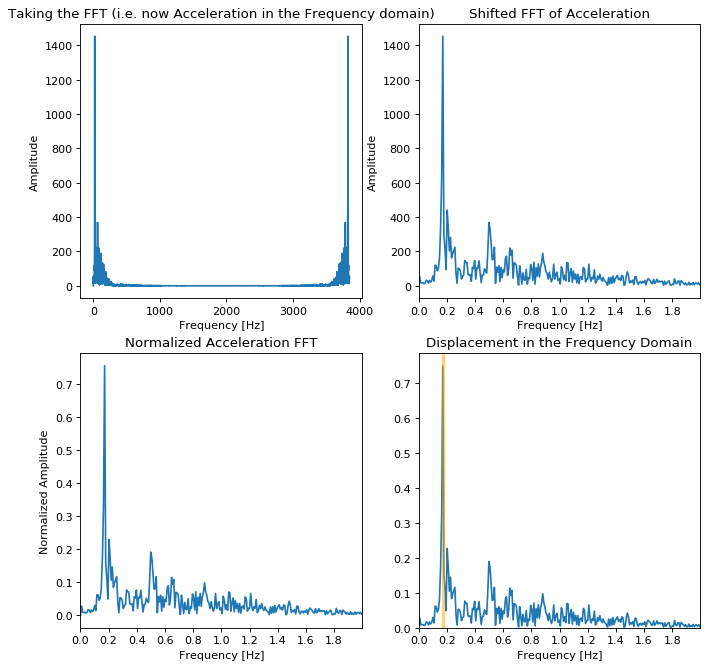

Peak frequency is:  0.17147310989867495
Wave height is:  1.4940760722392963


In [76]:
calc_displacement_fft(dacc_array1, f_s=30.0) 


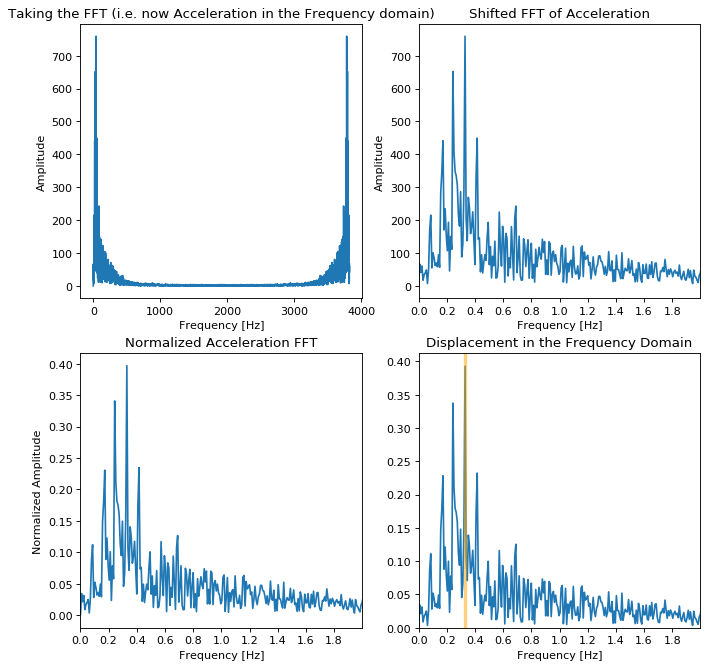

Peak frequency is:  0.32932566649242034
Wave height is:  0.7850887533077898


In [77]:
calc_displacement_fft(dacc_array2, f_s=30.0) 

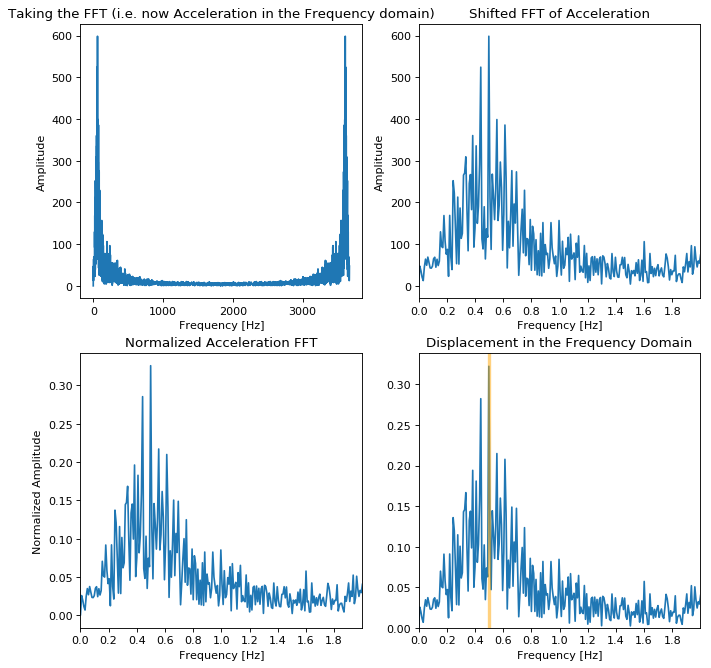

Peak frequency is:  0.49823032943098283
Wave height is:  0.6447125249060404


In [78]:
calc_displacement_fft(dacc_array3, f_s=30.0) 